# Welcome to week 8

This week it's all about k-nearest neighbour and the implementation of PCA.

# Section 1: kNN

The good news: Our trusted library sklearn has a nice kNN implementation available for our use. Have a look at the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

You will see some of the interesting parameters which we have discussed in the lecture:

- the number of neighbours k
- weights for the neighbours
- metric for the distance metric used

The 'algorithm' parameter lets you decide which algorithm is used to search for neighbours. There is a good article on which algorithm is the most suitable for which kind of problem [here](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms). The most basic one is 'brute', which stands for Brute Force. This algorithm simply computes the distance between each point pair. You can imagine that this is very effective, but not at all efficient if you have a large dataset. 'kd_tree' and 'ball_tree' are alternatives which work better in large and high dimensional datasets. If you're not at all sure, you can leave the default at 'auto' and sklearn will try to figure it out on its own.

**The data** we will be using today comes from the [UC Irvine Machine Learning repository](http://archive.ics.uci.edu/). This is an amazing source for datasets to work with for testing algorithms. The dataset of today will be their [Bank Marketing](http://archive.ics.uci.edu/dataset/222/bank+marketing) data. I have uploaded a csv copy of it to Learn, but you can also download it yourself from the source.

## 1.1 Loading in and pre-processing the data

We start by loading in our dataset, selecting the variables we are interested in and splitting it into train and test data. Remember that kNN is quite scale sensitive, so after splitting you want to standardise the variables to make the scales even.

Looking at the dataset, we have a binary class label (customer subscription 'y' yes/no) and a collection of integer and categorical variables. For simplicity reasons, we will just select two integer variables for prediction here. This is to avoid having the extra step of calculating a mixed datatype dissimilarity matrix separately from the kNN algorithm.

**TASK**

- Load in the dataset by downloading it from the source [here](http://archive.ics.uci.edu/dataset/222/bank+marketing) or downloading the provided csv file on Learn. I recommend using bank.csv which is the 10% sample of bank-full.csv
- select the class label 'y' and the predictors 'balance' and 'campaign'
- Split the data into training and test, using a split of your choice. I recommend 70/30 for training/test.
- Standardise both training and test data *separately* using the [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) function

Tip: Note how our outcome variable in the dataset is currently a string, consisting of "yes" or "no". Most models will want a numeric label for the prediction. We can use [LabelBinarizer()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) from the sklearn preprocessing library for that.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer


In [3]:
df = pd.read_csv("./bank.csv", sep=";")

df.head()

target = df["y"]
predictors = df[["balance", "campaign"]]

X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, test_size=0.3, random_state=8964
)

SS = StandardScaler()

# Standardize the training data
X_train_scaled = SS.fit_transform(X_train)

# Standardize the test data (using the scale of the training set)
X_test_scaled = SS.transform(X_test)

lb = LabelBinarizer()

# Fit and transform the 'y' column to binary format
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

In [4]:
print(X_test_scaled, y_test_binarized)

[[ 0.25950661  0.0824522 ]
 [-0.44811452 -0.60137158]
 [ 0.67308584 -0.60137158]
 ...
 [ 0.56778704  0.76627598]
 [ 0.13036659 -0.60137158]
 [-0.46798222  2.13392354]] [[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]


## 1.2 Selecting k

We will try to select the optimal value of k using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) today. This is a really handle function for hyperparameter optimisation, which allows us to compare multiple configurations of a model in terms of some evaluation parameter. For example, here we want to compare multiple versions of kNN with different values of k (our hyperparamter) and choose the best one.

There's a pretty [good article](https://scikit-learn.org/stable/modules/grid_search.html) on sklearn about hyperparameter tuning via, for example, GridSearch. We will implement this below.

The important parameters for [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) are 

- estimator, which in this case is our kNN classifier
- param_grid, which is your space of possible values for k which we want to test (I choose 1 to 20)
- scoring, which is your evaluation parameter (I choose accuracy)
- cv, which is your cross-validation parameter, for example the number of folds for your k-fold cross validation (I choose 5)

**TASK**

Implement GridSearchCV below to search for the optimal number of neighbours, k. Make sure to fit it to your training data only.

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# 设置KNN模型
knn = KNeighborsClassifier()

# 创建想要测试的K值的列表
param_grid = {"n_neighbors": list(range(1, 20))}  # 例如，这里测试从1到30的k值

# 使用交叉验证设置GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")

# 拟合模型
grid_search.fit(X_train_scaled, y_train)

# 查找最佳参数
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters for KNN: {best_params}")
print(f"Best cross-validation score: {best_score:.3f}")

Best parameters for KNN: {'n_neighbors': 16}
Best cross-validation score: 0.886


My GridSearch gave me k=10 as the optimal number of neighbours for our data. I will proceed with this below.

## 1.3 Implementing kNN

I will now implement kNN with k=10 and test the performance on the test data. You can calculate the accuracy of your model by using the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function in sklearns metrics. Make sure to test the accuracy on the test data, not the training data.

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
knn = KNeighborsClassifier(n_neighbors=best_params["n_neighbors"])

# Fit the classifier to the scaled training data
knn.fit(X_train_scaled, y_train_binarized)

# Predict the target values for the scaled test data
y_pred = knn.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_binarized, y_pred)

print(
    f"The accuracy of the kNN classifier with k=10 on the test data is: {accuracy:.2f}"
)

The accuracy of the kNN classifier with k=10 on the test data is: 0.88


c:\Users\redhawc\.pyenv\pyenv-win\versions\3.11.2\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


# Section 2: PCA and PCR

We remember that PCA can be used to reduce the number of predictors in our model. It can be used as a pre-processing step, or it can be used integrated into a regression model which we would then call PCR (Principle Component Regression).

This exercise will demonstrate how you can use PCR to create a model for stock market prediction which uses composite factors (principle components) instead of all available predictors.

I have uploaded a stock market dataset for this task. Please download it from Learn and upload it to your Noteable space to work with it.

We want to predict the one-month-ahead stock return using principal components extracted from a set of 67 stock characteristics.

In [9]:
# load data

import pandas as pd
data = pd.read_csv('stock_data.csv',index_col=0)

print(data.shape)
data.head()

(3481, 67)


,RET,CAPEI,bm,evm,pe_op_basic,pe_exi,pe_inc,ps,pcf,dpr,...,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb
1,-0.088191,0.759381,-0.999558,0.696751,0.079703,0.007577,-0.021611,-0.992676,0.147590,-0.956408,...,-0.998073,-0.932030,-0.870970,-0.987193,0.648937,-0.999998,-0.998952,-1.0,0.551959,-0.910672
2,0.079484,0.757554,-0.999718,0.700319,-0.130809,-0.176777,-0.208520,-0.998950,-0.447588,-0.958060,...,-0.973573,-0.932865,-0.801126,-0.926463,0.649039,-1.000000,-0.995808,-1.0,0.549097,-0.916289
3,-0.015975,0.758821,-0.999205,0.696543,0.022296,-0.046242,-0.076176,-0.997872,0.103177,-0.959754,...,-0.998721,-0.936796,-0.863408,-0.980141,0.648930,-1.000000,-1.000000,-1.0,0.550775,-0.956189
4,0.051836,0.758721,-0.999590,0.696393,0.027334,-0.041370,-0.071237,-0.994922,0.107730,-0.952962,...,-0.998041,-0.928855,-0.869320,-0.984026,0.648950,-1.000000,-0.996647,-1.0,0.552304,-0.916565
5,0.095178,0.758717,-0.999612,0.696722,0.027037,-0.039758,-0.069602,-0.985473,0.108669,-0.957310,...,-0.998229,-0.931362,-0.882201,-0.994100,0.648897,-0.999702,-0.999371,-1.0,0.551169,-0.918346


In [10]:
# define predictors and outcome - we want to predict RET which is the stock return

y = data['RET']
X = data.drop('RET',axis=1)

## 2.1 PCA

The sklearn library has a great PCA function within its decomposition collection. You can have a look at the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

**TASK**

Use that function below to construct the principle components from your dataset X. In order to then decide how many components are optimal for our data, you can plot a Scree plot which plots the PCA components ('components_') on the x-axis and the explained variance ratio ('explained_variance_ratio_') on the y-axis. You will recognise this approach from our Elbow criterion when we were selecting the optimal number of clusters for k-means.

Remember that we want to select the number of components explaining around 70-80% of the variance in the dataset. 

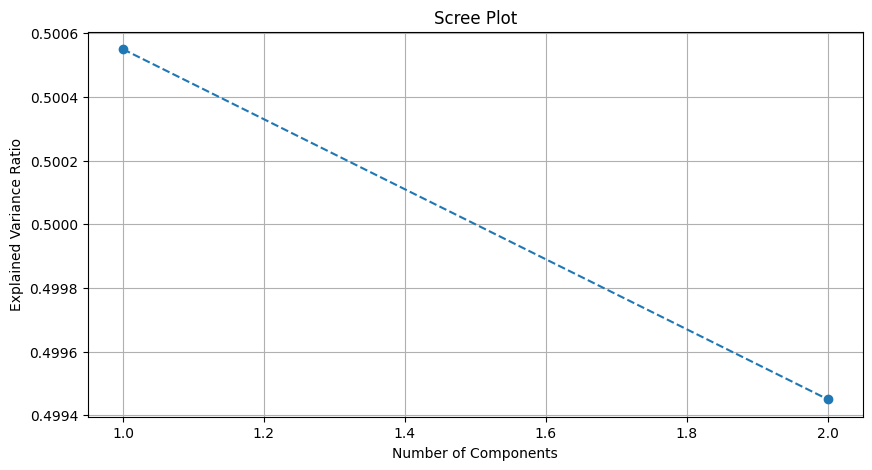

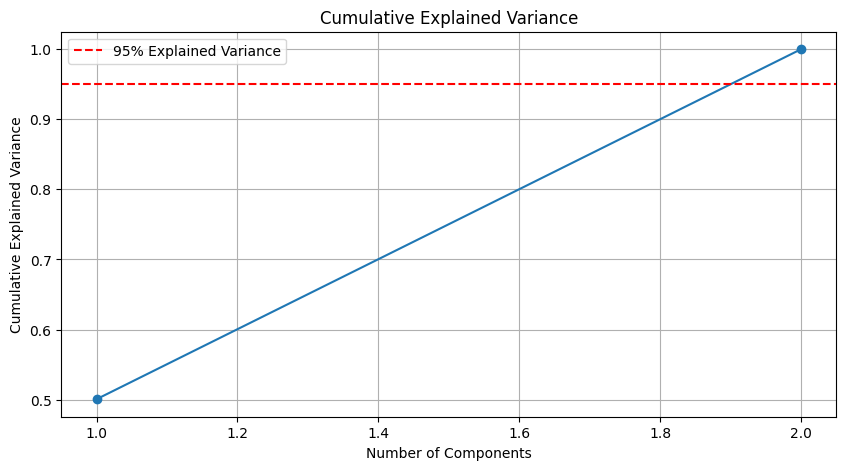

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA and fit it to the data
pca = PCA().fit(X_train_scaled, y_train_binarized)

# Extract the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a Scree plot
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker="o",
    linestyle="--",
)
plt.title("Scree Plot")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="-",
)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Explained Variance")
plt.legend(loc="best")
plt.grid(True)
plt.show()

A Scree plot is great, but it can be difficult to read in detail. You can also have a look at the raw values of the explained variance ratio and look for the optimal value there. 

**OPTIONAL TASK**

Look at the explained variance ratio values and decide how many principle components are optimal.

In [17]:
cumulative_explained_variance

array([0.50054953, 1.        ])

We can see that the first three components explain 63.79% of variance in our dataset. Let's say that we're happy with that level and we decide to keep the first **THREE** components.

## 2.2 Plotting the component loadings

**OPTIONAL TASK**

This is a bit tricky and not necessary for the following analysis, so plotting is an optional task here. But you can try to plot the PCA coefficients (loadings) for the first 3 components. That will help us visualise the spread of data that is being explained between the components.

Each point corresponds to loadings of one of the 66 variables, so you can theoretically see 66 dots in the plots (though a lot will be overlapping). They explain how strongly each of the variables "load" onto the component - that means how strongly they play their part in the construction of this component.

Points around the 0/0 point of the plot don't have much impact on either of these two components. Those further along the axes have a higher loading on one (or both) of the components.

To some extent, this can help you interpret the components, but that explanation part is very limited so don't put too much weight on it.

If you'd like to try it, there are some great step by step tutorials online. Alternatively, you will have access to my proposed solution after the lab as usual.

In [13]:
# YOUR CODE HERE

## 2.3 Principle Component Regression (PCR)

Now that we have learned how to construct principle components, we can construct a predictive model with those as predictors.

**TASK**

You will need to repeat the construction step, because we want to construct the components using **just** the training data! So, do your usual data splitting first, then repeat the step from 2.1 using X_train instead of the whole X. Save those as a new X, called for example X_reduced.

In [14]:
# YOUR CODE HERE

**TASK**

I will now do cross-validation to select the optimal number of components. For PCR, the optimal number of components minimises our model error. I will run 5 folds of cross-validation using the [KFold function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) in sklearn. This allows me to calculate multiple values of MSE for different numbers of components. Then I will plot the number of components on the x-axis and the MSE on the y-axis. 

You can use a different approach for this if you prefer. In the end, the purpose of this is to select the optimal number of components again for our model building in the next step.

In [15]:
# YOUR CODE HERE

Finally we can construct our PCR model using training X and training Y, then testing on test X and test Y as usual.

In [16]:
# YOUR CODE HERE

**Dataset acknowledgement**

Moro,S., Rita,P., and Cortez,P.. (2012). Bank Marketing. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306. Licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.